In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


In [4]:
DATA_PATH = "/kaggle/input/datasets/vikasherhgs/dataset/Vikash/train"

dataset = datasets.ImageFolder(
    root=DATA_PATH,
    transform=train_transform
)

print("Classes:", dataset.classes)


Classes: ['fire', 'normal', 'smoke']


In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

val_data.dataset.transform = val_transform

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)


In [6]:
model = models.convnext_tiny(weights="DEFAULT")

model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 200MB/s] 


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [8]:
epochs = 20
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    val_acc = 100 * correct / total
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print("-"*30)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/convnext_fire_model.pth")
        print("✅ Best model saved!")


Epoch 1
Train Loss: 9.2792
Validation Accuracy: 99.33%
------------------------------
✅ Best model saved!
Epoch 2
Train Loss: 1.5397
Validation Accuracy: 98.67%
------------------------------
Epoch 3
Train Loss: 0.6338
Validation Accuracy: 98.67%
------------------------------
Epoch 4
Train Loss: 0.2031
Validation Accuracy: 98.89%
------------------------------
Epoch 5
Train Loss: 0.0327
Validation Accuracy: 99.11%
------------------------------
Epoch 6
Train Loss: 0.0192
Validation Accuracy: 99.11%
------------------------------
Epoch 7
Train Loss: 0.0192
Validation Accuracy: 99.33%
------------------------------
Epoch 8
Train Loss: 0.0230
Validation Accuracy: 98.67%
------------------------------
Epoch 9
Train Loss: 0.0159
Validation Accuracy: 98.89%
------------------------------
Epoch 10
Train Loss: 0.0056
Validation Accuracy: 98.89%
------------------------------
Epoch 11
Train Loss: 0.0059
Validation Accuracy: 99.11%
------------------------------
Epoch 12
Train Loss: 0.0053
Vali

In [9]:
model.load_state_dict(torch.load("/kaggle/working/convnext_fire_model.pth"))
model.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

class_names = dataset.classes

def test_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img = val_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
    
    predicted_class = class_names[pred.item()]
    confidence = conf.item()
    
    if predicted_class in ["fire", "smoke"]:
        result = "FIRE WARNING ALERT"
    else:
        result = "NO ISSUE"
    
    plt.imshow(image)
    plt.title(f"{result} ({confidence:.2f})")
    plt.axis("off")
    plt.show()
    
    print("Raw Prediction:", predicted_class)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


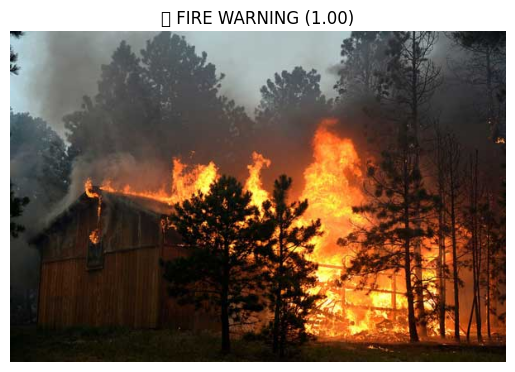

Raw Prediction: fire


In [11]:
test_image("/kaggle/input/datasets/vikasherhgs/dataset/Vikash/train/fire/20130611_100618_Black-Forest-Fire-engulfs-house.jpg")
